In [ ]:
# Install necessary libraries
!pip install tensorflow opencv-python pillow scikit-learn matplotlib seaborn

In [ ]:
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import random
from collections import defaultdict
import shutil

In [ ]:
from google.colab import files
import os

# Upload the zip file
print("Please upload your footrot.zip file...")
uploaded = files.upload()

# Extract the zip file
zip_path = list(uploaded.keys())[0]
extract_path = '/content/footrot_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully!")
print("Contents of the dataset folder:")
for root, dirs, files in os.walk(extract_path):
    level = root.replace(extract_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for file in files[:5]:  # Show first 5 files in each directory
        print(f'{subindent}{file}')
    if len(files) > 5:
        print(f'{subindent}... and {len(files) - 5} more files')

Please upload your footrot.zip file...


Saving footrot.zip to footrot.zip
Dataset extracted successfully!
Contents of the dataset folder:
footrot_dataset/
  footrot/
    fmd/
      augmented_fmdf_19 (3).jpg
      augmented_fmdf_13 (4).jpg
      augmented_fmdf_2.jpg
      augmented_fmdf_6 (6).jpg
      augmented_fmdf_22 (4).jpg
      ... and 194 more files
    NON CATTLE IMAGES/
      dog_9.jpg
      0042.jpg
      Screenshot 2025-10-04 144021.png
      0068.jpg
      portrait-beautiful-sad-young-woman-unhappy-face-looking-miserable-melancholy-human-facial-expressions-negative-139155053.jpg
      ... and 477 more files
    healthy/
      augmented_fmdf_19 (3).jpg
      augmented_fmdf_7 (8).jpg
      augmented_fmdf_13 (4).jpg
      augmented_fmdf_16 (8).jpg
      augmented_fmdf_2.jpg
      ... and 194 more files


In [ ]:
def analyze_dataset(base_path):
    """Analyze the dataset structure and identify potential duplicates"""
    class_counts = {}
    total_images = 0

    print("Dataset Analysis:")
    print("-" * 50)

    # Updated path to the actual dataset location
    dataset_path = os.path.join(base_path, 'footrot')

    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            class_counts[class_name] = len(images)
            total_images += len(images)

            print(f"{class_name}: {len(images)} images")

            # Show sample filenames to identify patterns
            if images:
                print(f"  Sample files: {images[:3]}")

    print("-" * 50)
    print(f"Total images: {total_images}")

    return class_counts, dataset_path

# Analyze the dataset with correct path
base_path = '/content/footrot_dataset'
class_counts, dataset_path = analyze_dataset(base_path)
print(f"Dataset path: {dataset_path}")

Dataset Analysis:
--------------------------------------------------
fmd: 199 images
  Sample files: ['augmented_fmdf_19 (3).jpg', 'augmented_fmdf_13 (4).jpg', 'augmented_fmdf_2.jpg']
NON CATTLE IMAGES: 482 images
  Sample files: ['dog_9.jpg', '0042.jpg', 'Screenshot 2025-10-04 144021.png']
healthy: 199 images
  Sample files: ['augmented_fmdf_19 (3).jpg', 'augmented_fmdf_7 (8).jpg', 'augmented_fmdf_13 (4).jpg']
--------------------------------------------------
Total images: 880
Dataset path: /content/footrot_dataset/footrot


In [ ]:
def group_images_by_animal(image_list):
    """Group images that likely belong to the same animal"""
    animal_groups = defaultdict(list)

    for img_name in image_list:
        # Extract base name without augmentation indicators
        base_name = img_name.lower()

        # Remove augmentation patterns and file extensions
        import re
        # Remove text in parentheses (augmentation indicators)
        base_name = re.sub(r'\s*\(\d+\)', '', base_name)
        # Remove file extensions
        base_name = re.sub(r'\.(jpg|jpeg|png)$', '', base_name)
        # Remove "augmented_" prefix if present
        base_name = base_name.replace('augmented_', '')

        # Use the base name as animal ID
        animal_id = base_name
        animal_groups[animal_id].append(img_name)

    return animal_groups

def create_proper_splits(dataset_path, output_path, test_size=0.2, val_size=0.15):
    """Create train/validation/test splits ensuring no data leakage"""

    # Create output directories
    splits = ['train', 'val', 'test']
    classes = list(class_counts.keys())

    for split in splits:
        for class_name in classes:
            os.makedirs(os.path.join(output_path, split, class_name), exist_ok=True)

    # Process each class
    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if not images:
            print(f"No images found in {class_path}")
            continue

        # Group images by animal
        animal_groups = group_images_by_animal(images)
        animal_ids = list(animal_groups.keys())

        print(f"\n{class_name}: Found {len(animal_ids)} unique animals from {len(images)} total images")

        # Check if we have enough animals for splitting
        if len(animal_ids) < 3:
            print(f"Warning: Only {len(animal_ids)} unique animals in {class_name}. Using image-level splitting instead.")
            # Fallback to image-level splitting for classes with very few animals
            train_images, test_images = train_test_split(images, test_size=test_size, random_state=42)
            train_images, val_images = train_test_split(train_images, test_size=val_size/(1-test_size), random_state=42)

            # Copy images to respective splits
            for img_name in train_images:
                src = os.path.join(class_path, img_name)
                dst = os.path.join(output_path, 'train', class_name, img_name)
                shutil.copy2(src, dst)

            for img_name in val_images:
                src = os.path.join(class_path, img_name)
                dst = os.path.join(output_path, 'val', class_name, img_name)
                shutil.copy2(src, dst)

            for img_name in test_images:
                src = os.path.join(class_path, img_name)
                dst = os.path.join(output_path, 'test', class_name, img_name)
                shutil.copy2(src, dst)

            print(f"  Train: {len(train_images)} images")
            print(f"  Val: {len(val_images)} images")
            print(f"  Test: {len(test_images)} images")

        else:
            # Split animal IDs (not individual images)
            train_animals, test_animals = train_test_split(animal_ids, test_size=test_size, random_state=42)
            train_animals, val_animals = train_test_split(train_animals, test_size=val_size/(1-test_size), random_state=42)

            # Copy images to respective splits
            for animal_id in train_animals:
                for img_name in animal_groups[animal_id]:
                    src = os.path.join(class_path, img_name)
                    dst = os.path.join(output_path, 'train', class_name, img_name)
                    shutil.copy2(src, dst)

            for animal_id in val_animals:
                for img_name in animal_groups[animal_id]:
                    src = os.path.join(class_path, img_name)
                    dst = os.path.join(output_path, 'val', class_name, img_name)
                    shutil.copy2(src, dst)

            for animal_id in test_animals:
                for img_name in animal_groups[animal_id]:
                    src = os.path.join(class_path, img_name)
                    dst = os.path.join(output_path, 'test', class_name, img_name)
                    shutil.copy2(src, dst)

            train_count = sum(len(animal_groups[animal_id]) for animal_id in train_animals)
            val_count = sum(len(animal_groups[animal_id]) for animal_id in val_animals)
            test_count = sum(len(animal_groups[animal_id]) for animal_id in test_animals)

            print(f"  Train: {len(train_animals)} animals ({train_count} images)")
            print(f"  Val: {len(val_animals)} animals ({val_count} images)")
            print(f"  Test: {len(test_animals)} animals ({test_count}) images")

# Create proper splits with correct path
output_path = '/content/footrot_splits'
create_proper_splits(dataset_path, output_path)


fmd: Found 89 unique animals from 199 total images
  Train: 57 animals (122 images)
  Val: 14 animals (24 images)
  Test: 18 animals (53) images

NON CATTLE IMAGES: Found 450 unique animals from 482 total images
  Train: 292 animals (311 images)
  Val: 68 animals (70 images)
  Test: 90 animals (101) images

healthy: Found 47 unique animals from 199 total images
  Train: 30 animals (132 images)
  Val: 7 animals (31 images)
  Test: 10 animals (36) images


In [ ]:
# Verify the splits were created correctly
def verify_splits(splits_path):
    print("\nVerifying Dataset Splits:")
    print("-" * 40)

    for split in ['train', 'val', 'test']:
        split_path = os.path.join(splits_path, split)
        print(f"\n{split.upper()} Split:")
        for class_name in os.listdir(split_path):
            class_path = os.path.join(split_path, class_name)
            if os.path.isdir(class_path):
                images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                print(f"  {class_name}: {len(images)} images")

verify_splits(output_path)


Verifying Dataset Splits:
----------------------------------------

TRAIN Split:
  fmd: 122 images
  footrot: 0 images
  NON CATTLE IMAGES: 311 images
  healthy: 132 images

VAL Split:
  fmd: 24 images
  footrot: 0 images
  NON CATTLE IMAGES: 70 images
  healthy: 31 images

TEST Split:
  fmd: 53 images
  footrot: 0 images
  NON CATTLE IMAGES: 101 images
  healthy: 36 images


In [ ]:
# Set parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = len(class_counts)

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    channel_shift_range=0.2
)

# Validation and test data (only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators with correct paths
train_generator = train_datagen.flow_from_directory(
    '/content/footrot_splits/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    '/content/footrot_splits/val',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    '/content/footrot_splits/test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Print class indices
print("Class indices:", train_generator.class_indices)

Found 565 images belonging to 4 classes.
Found 125 images belonging to 4 classes.
Found 190 images belonging to 4 classes.
Class indices: {'NON CATTLE IMAGES': 0, 'fmd': 1, 'footrot': 2, 'healthy': 3}


In [ ]:
# Check class distribution in each split
def check_class_distribution(generator, split_name):
    print(f"\n{split_name.upper()} Class Distribution:")
    unique, counts = np.unique(generator.classes, return_counts=True)
    for i, (class_idx, count) in enumerate(zip(unique, counts)):
        class_name = list(generator.class_indices.keys())[class_idx]
        print(f"  {class_name}: {count} images")

check_class_distribution(train_generator, "training")
check_class_distribution(val_generator, "validation")
check_class_distribution(test_generator, "test")


TRAINING Class Distribution:
  NON CATTLE IMAGES: 311 images
  fmd: 122 images
  healthy: 132 images

VALIDATION Class Distribution:
  NON CATTLE IMAGES: 70 images
  fmd: 24 images
  healthy: 31 images

TEST Class Distribution:
  NON CATTLE IMAGES: 101 images
  fmd: 53 images
  healthy: 36 images


In [ ]:
# Remove the empty 'footrot' directory from splits
import shutil

for split in ['train', 'val', 'test']:
    footrot_path = os.path.join(output_path, split, 'footrot')
    if os.path.exists(footrot_path):
        shutil.rmtree(footrot_path)
        print(f"Removed empty directory: {footrot_path}")

# Recreate data generators without the empty class
train_generator = train_datagen.flow_from_directory(
    '/content/footrot_splits/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    '/content/footrot_splits/val',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    '/content/footrot_splits/test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Print updated class indices
print("Updated Class indices:", train_generator.class_indices)
NUM_CLASSES = len(train_generator.class_indices)
print(f"Number of classes: {NUM_CLASSES}")

# Check updated distribution
check_class_distribution(train_generator, "training")
check_class_distribution(val_generator, "validation")
check_class_distribution(test_generator, "test")

Removed empty directory: /content/footrot_splits/train/footrot
Removed empty directory: /content/footrot_splits/val/footrot
Removed empty directory: /content/footrot_splits/test/footrot
Found 565 images belonging to 3 classes.
Found 125 images belonging to 3 classes.
Found 190 images belonging to 3 classes.
Updated Class indices: {'NON CATTLE IMAGES': 0, 'fmd': 1, 'healthy': 2}
Number of classes: 3

TRAINING Class Distribution:
  NON CATTLE IMAGES: 311 images
  fmd: 122 images
  healthy: 132 images

VALIDATION Class Distribution:
  NON CATTLE IMAGES: 70 images
  fmd: 24 images
  healthy: 31 images

TEST Class Distribution:
  NON CATTLE IMAGES: 101 images
  fmd: 53 images
  healthy: 36 images


In [ ]:
def create_mobilenet_model(num_classes, img_size=IMG_SIZE):
    """Create MobileNetV2 model with custom classifier"""

    # Load pre-trained MobileNetV2
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(img_size[0], img_size[1], 3)
    )

    # Freeze base model layers initially
    base_model.trainable = False

    # Add custom classifier
    inputs = keras.Input(shape=(img_size[0], img_size[1], 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    return model, base_model

# Create model
model, base_model = create_mobilenet_model(NUM_CLASSES)

# Display model architecture
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,048,003 (11.63 MB)

 Trainable params: 788,995 (3.01 MB)

 Non-trainable params: 2,259,008 (8.62 MB)

In [ ]:
# Calculate class weights for imbalanced data
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))

print("Class weights for imbalance handling:")
for class_idx, weight in class_weight_dict.items():
    class_name = list(train_generator.class_indices.keys())[class_idx]
    print(f"  {class_name}: {weight:.2f}")

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

print("Model compiled successfully!")

Class weights for imbalance handling:
  NON CATTLE IMAGES: 0.61
  fmd: 1.54
  healthy: 1.43
Model compiled successfully!


In [ ]:
# Callbacks for better training
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=8,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_mobilenet_footrot_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

print("Callbacks configured:")
for callback in callbacks:
    print(f"  - {callback.__class__.__name__}")

Callbacks configured:
  - EarlyStopping
  - ReduceLROnPlateau
  - ModelCheckpoint


In [ ]:
print("Starting Phase 1: Training classifier layers only...")
print("=" * 60)

# Calculate steps per epoch (convert to integers)
train_steps = int(np.ceil(len(train_generator.filenames) / BATCH_SIZE))
val_steps = int(np.ceil(len(val_generator.filenames) / BATCH_SIZE))

print(f"Training samples: {len(train_generator.filenames)}")
print(f"Validation samples: {len(val_generator.filenames)}")
print(f"Train steps per epoch: {train_steps}")
print(f"Val steps per epoch: {val_steps}")

# Train with frozen base model
history1 = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=25,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

print("Phase 1 training completed!")

Starting Phase 1: Training classifier layers only...
Training samples: 565
Validation samples: 125
Train steps per epoch: 18
Val steps per epoch: 4
Epoch 1/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6594 - loss: 0.7750 - precision: 0.6718 - recall: 0.6292
Epoch 1: val_accuracy improved from -inf to 0.80000, saving model to best_mobilenet_footrot_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6675 - loss: 0.7583 - precision: 0.6799 - recall: 0.6380 - val_accuracy: 0.8000 - val_loss: 0.6526 - val_precision: 0.8230 - val_recall: 0.7440 - learning_rate: 0.0010
Epoch 2/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - accuracy: 0.9436 - loss: 0.1222 - precision: 0.9493 - recall: 0.9428
Epoch 2: val_accuracy improved from 0.80000 to 0.92000, saving model to best_mobilenet_footrot_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 797ms/step - accuracy: 0.9441 - loss: 0.1224 - precision: 0.9496 - recall: 0.9432 - val_accuracy: 0.9200 - val_loss: 0.1859 - val_precision: 0.9500 - val_recall: 0.9120 - learning_rate: 0.0010
Epoch 3/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9662 - loss: 0.1056 - precision: 0.9662 - recall: 0.9662
Epoch 3: val_accuracy improved from 0.92000 to 0.97600, saving model to best_mobilenet_footrot_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 836ms/step - accuracy: 0.9666 - loss: 0.1042 - precision: 0.9666 - recall: 0.9666 - val_accuracy: 0.9760 - val_loss: 0.0686 - val_precision: 0.9760 - val_recall: 0.9760 - learning_rate: 0.0010
Epoch 4/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.9849 - loss: 0.0479 - precision: 0.9858 - recall: 0.9849
Epoch 4: val_accuracy improved from 0.97600 to 0.98400, saving model to best_mobilenet_footrot_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 797ms/step - accuracy: 0.9849 - loss: 0.0483 - precision: 0.9859 - recall: 0.9849 - val_accuracy: 0.9840 - val_loss: 0.0488 - val_precision: 0.9840 - val_recall: 0.9840 - learning_rate: 0.0010
Epoch 5/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - accuracy: 0.9739 - loss: 0.0596 - precision: 0.9739 - recall: 0.9739
Epoch 5: val_accuracy did not improve from 0.98400
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 752ms/step - accuracy: 0.9742 - loss: 0.0589 - precision: 0.9742 - recall: 0.9742 - val_accuracy: 0.9760 - val_loss: 0.0548 - val_precision: 0.9760 - val_recall: 0.9760 - learning_rate: 0.0010
Epoch 6/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.9824 - loss: 0.0431 - precision: 0.9824 - recall: 0.9824
Epoch 6: val_accuracy did not improve from 0.98400
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 744ms/step - accuracy: 0.9823 - loss: 0.0442 - precision: 0.9823 - recall: 0.9823 - val_accuracy: 0.9840 - val_loss: 0.0353 - val_precision: 0.9840 - val_recall: 0.9840 - le

18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 793ms/step - accuracy: 0.9845 - loss: 0.0414 - precision: 0.9845 - recall: 0.9845 - val_accuracy: 0.9920 - val_loss: 0.0182 - val_precision: 0.9920 - val_recall: 0.9920 - learning_rate: 0.0010
Epoch 14/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - accuracy: 0.9917 - loss: 0.0248 - precision: 0.9919 - recall: 0.9917
Epoch 14: val_accuracy improved from 0.99200 to 1.00000, saving model to best_mobilenet_footrot_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 790ms/step - accuracy: 0.9915 - loss: 0.0250 - precision: 0.9918 - recall: 0.9915 - val_accuracy: 1.0000 - val_loss: 0.0113 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 15/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.9950 - loss: 0.0408 - precision: 0.9950 - recall: 0.9950
Epoch 15: val_accuracy did not improve from 1.00000
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 772ms/step - accuracy: 0.9949 - loss: 0.0415 - precision: 0.9949 - recall: 0.9949 - val_accuracy: 0.9840 - val_loss: 0.0804 - val_precision: 0.9840 - val_recall: 0.9840 - learning_rate: 0.0010
Epoch 16/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - accuracy: 0.9818 - loss: 0.0453 - precision: 0.9818 - recall: 0.9818
Epoch 16: val_accuracy did not improve from 1.00000
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 820ms/step - accuracy: 0.9822 - loss: 0.0446 - precision: 0.9822 - recall: 0.9822 - val_accuracy: 0.9840 - val_loss: 0.0450 - val_precision: 0.9840 - val_recall: 0.9840 

In [ ]:
print("\nStarting Phase 2: Fine-tuning with unfrozen layers...")
print("=" * 60)

# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100  # You can adjust this

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print(f"Number of layers in base model: {len(base_model.layers)}")
print(f"Number of trainable layers: {sum([layer.trainable for layer in base_model.layers])}")

# Recompile with lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=0.0001/10),  # Very low learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Continue training
initial_epoch = len(history1.history['loss'])
total_epochs = initial_epoch + 25  # Add 25 more epochs

history2 = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=total_epochs,
    initial_epoch=initial_epoch,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

print("Phase 2 training completed!")


Starting Phase 2: Fine-tuning with unfrozen layers...
Number of layers in base model: 154
Number of trainable layers: 54
Epoch 26/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9490 - loss: 0.1844 - precision: 0.9491 - recall: 0.9490
Epoch 26: val_accuracy did not improve from 1.00000
18/18 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.9494 - loss: 0.1844 - precision: 0.9495 - recall: 0.9494 - val_accuracy: 1.0000 - val_loss: 0.0130 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 1.0000e-05
Epoch 27/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - accuracy: 0.9484 - loss: 0.2680 - precision: 0.9529 - recall: 0.9484
Epoch 27: val_accuracy did not improve from 1.00000
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 783ms/step - accuracy: 0.9484 - loss: 0.2667 - precision: 0.9529 - recall: 0.9484 - val_accuracy: 0.9840 - val_loss: 0.0202 - val_precision: 0.9840 - val_recall: 0.9840 - learning_rate: 1.0000e-05
Epoch 28/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.9741 - lo

In [ ]:
# Combine histories from both phases
def combine_histories(history1, history2):
    combined_history = {}
    for key in history1.history.keys():
        combined_history[key] = history1.history[key] + history2.history[key]
    return combined_history

if 'history2' in locals():
    combined_history = combine_histories(history1, history2)
else:
    combined_history = history1.history

print(f"Total training epochs: {len(combined_history['loss'])}")

Total training epochs: 41


In [ ]:
print("Evaluating model on test set...")
print("=" * 50)

# Recreate the model architecture first
def create_evaluation_model(num_classes, img_size=IMG_SIZE):
    """Create the same MobileNetV2 model architecture for evaluation"""

    # Load pre-trained MobileNetV2 with the same configuration
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(img_size[0], img_size[1], 3)
    )

    # Freeze base model layers
    base_model.trainable = False

    # Add the same custom classifier
    inputs = keras.Input(shape=(img_size[0], img_size[1], 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    return model

# Create a fresh model with the same architecture
eval_model = create_evaluation_model(NUM_CLASSES)

# Compile the model (same as before)
eval_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Try to load weights, if it fails, use the current trained model
try:
    eval_model.load_weights('best_mobilenet_footrot_model.h5')
    print("✅ Loaded best model weights successfully!")
    model_to_use = eval_model
except Exception as e:
    print(f"⚠️ Could not load saved weights: {e}")
    print("Using the currently trained model instead...")
    model_to_use = model

# Evaluate on test set
test_steps = int(np.ceil(len(test_generator.filenames) / BATCH_SIZE))
test_loss, test_accuracy, test_precision, test_recall = model_to_use.evaluate(
    test_generator,
    steps=test_steps,
    verbose=1
)

print(f"\n📊 TEST SET RESULTS:")
print(f"🔹 Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"🔹 Precision: {test_precision:.4f}")
print(f"🔹 Recall: {test_recall:.4f}")
print(f"🔹 Loss: {test_loss:.4f}")

# Predictions for detailed analysis
test_generator.reset()
predictions = model_to_use.predict(test_generator, steps=test_steps, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

Evaluating model on test set...
✅ Loaded best model weights successfully!
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 1.0000 - loss: 0.0058 - precision: 1.0000 - recall: 1.0000

📊 TEST SET RESULTS:
🔹 Accuracy: 1.0000 (100.00%)
🔹 Precision: 1.0000
🔹 Recall: 1.0000
🔹 Loss: 0.0099
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step



DETAILED PERFORMANCE ANALYSIS

📈 CLASSIFICATION REPORT:
                   precision    recall  f1-score   support

NON CATTLE IMAGES     1.0000    1.0000    1.0000       101
              fmd     1.0000    1.0000    1.0000        53
          healthy     1.0000    1.0000    1.0000        36

         accuracy                         1.0000       190
        macro avg     1.0000    1.0000    1.0000       190
     weighted avg     1.0000    1.0000    1.0000       190



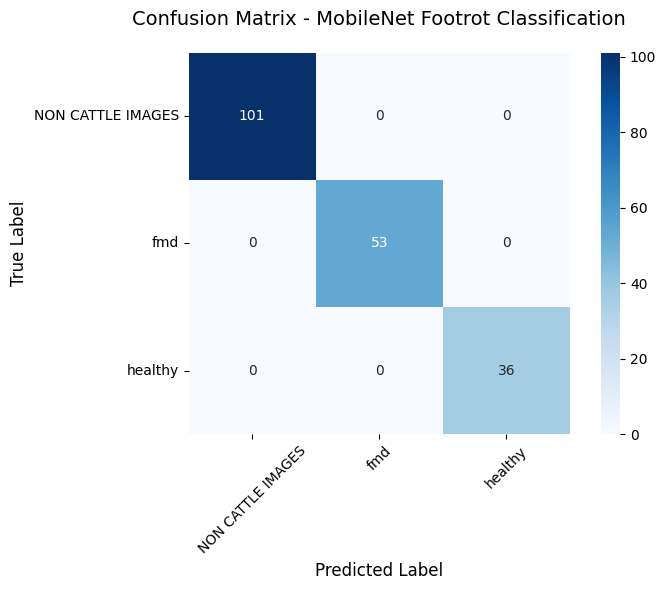


🎯 PER-CLASS ACCURACY:
  NON CATTLE IMAGES: 1.0000 (100.00%)
  fmd: 1.0000 (100.00%)
  healthy: 1.0000 (100.00%)

📊 PER-CLASS METRICS:
  NON CATTLE IMAGES:
    Precision: 1.0000
    Recall: 1.0000
    F1-Score: 1.0000
    Support: 101
  fmd:
    Precision: 1.0000
    Recall: 1.0000
    F1-Score: 1.0000
    Support: 53
  healthy:
    Precision: 1.0000
    Recall: 1.0000
    F1-Score: 1.0000
    Support: 36


In [ ]:
print("\n" + "="*60)
print("DETAILED PERFORMANCE ANALYSIS")
print("="*60)

# Classification Report
print("\n📈 CLASSIFICATION REPORT:")
print(classification_report(true_classes, predicted_classes,
                          target_names=class_labels, digits=4))

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels,
            square=True)
plt.title('Confusion Matrix - MobileNet Footrot Classification', fontsize=14, pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Calculate per-class accuracy
print("\n🎯 PER-CLASS ACCURACY:")
for i, class_name in enumerate(class_labels):
    class_mask = true_classes == i
    if np.sum(class_mask) > 0:
        class_accuracy = np.mean(predicted_classes[class_mask] == i)
        print(f"  {class_name}: {class_accuracy:.4f} ({class_accuracy*100:.2f}%)")

# Calculate per-class precision, recall, f1
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    true_classes, predicted_classes, average=None
)

print("\n📊 PER-CLASS METRICS:")
for i, class_name in enumerate(class_labels):
    print(f"  {class_name}:")
    print(f"    Precision: {precision[i]:.4f}")
    print(f"    Recall: {recall[i]:.4f}")
    print(f"    F1-Score: {f1[i]:.4f}")
    print(f"    Support: {support[i]}")

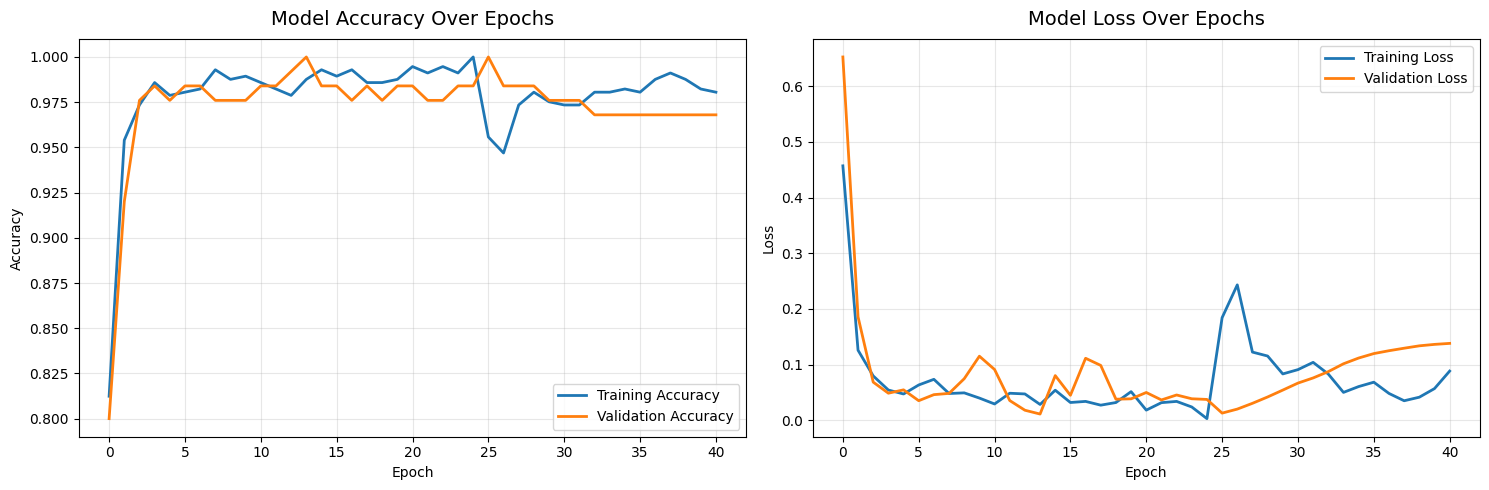

In [ ]:
# Plot training history
plt.figure(figsize=(15, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(combined_history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(combined_history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy Over Epochs', fontsize=14, pad=10)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Loss
plt.subplot(1, 2, 2)
plt.plot(combined_history['loss'], label='Training Loss', linewidth=2)
plt.plot(combined_history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss Over Epochs', fontsize=14, pad=10)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot learning rate if available
if 'lr' in combined_history:
    plt.figure(figsize=(10, 4))
    plt.plot(combined_history['lr'], linewidth=2)
    plt.title('Learning Rate Over Epochs', fontsize=14, pad=10)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
import pandas as pd
import json

# Save the final model (use the working one)
try:
    model_to_use.save('footrot_mobilenet_final_model.h5')
    print("✅ Final model saved as 'footrot_mobilenet_final_model.h5'")

    # Also save in the newer format
    model_to_use.save('footrot_mobilenet_final_model.keras')
    print("✅ Final model saved as 'footrot_mobilenet_final_model.keras'")
except Exception as e:
    print(f"⚠️ Could not save model: {e}")

# Save class indices for future use
with open('class_indices.json', 'w') as f:
    json.dump(train_generator.class_indices, f)
print("✅ Class indices saved as 'class_indices.json'")

# Save training history
history_df = pd.DataFrame(combined_history)
history_df.to_csv('training_history.csv', index=False)
print("✅ Training history saved as 'training_history.csv'")

# Save evaluation results
eval_results = {
    'test_accuracy': float(test_accuracy),
    'test_precision': float(test_precision),
    'test_recall': float(test_recall),
    'test_loss': float(test_loss),
    'class_distribution': {
        class_name: int(np.sum(true_classes == i))
        for i, class_name in enumerate(class_labels)
    },
    'per_class_metrics': {
        class_name: {
            'precision': float(precision[i]),
            'recall': float(recall[i]),
            'f1_score': float(f1[i]),
            'support': int(support[i])
        }
        for i, class_name in enumerate(class_labels)
    }
}

with open('evaluation_results.json', 'w') as f:
    json.dump(eval_results, f, indent=2)
print("✅ Evaluation results saved as 'evaluation_results.json'")

✅ Final model saved as 'footrot_mobilenet_final_model.h5'
✅ Final model saved as 'footrot_mobilenet_final_model.keras'
✅ Class indices saved as 'class_indices.json'
✅ Training history saved as 'training_history.csv'
✅ Evaluation results saved as 'evaluation_results.json'


In [ ]:
def predict_single_image(image_path, model, class_labels, img_size=IMG_SIZE):
    """Predict a single image"""
    try:
        # Load and preprocess image
        img = keras.preprocessing.image.load_img(image_path, target_size=img_size)
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0

        # Make prediction
        prediction = model.predict(img_array, verbose=0)
        predicted_class_idx = np.argmax(prediction)
        predicted_class = class_labels[predicted_class_idx]
        confidence = np.max(prediction)

        # Get all class probabilities
        class_probabilities = {
            class_labels[i]: float(prediction[0][i])
            for i in range(len(class_labels))
        }

        return predicted_class, confidence, class_probabilities
    except Exception as e:
        print(f"Error predicting image: {e}")
        return None, 0, {}

# Test prediction on sample images from each class
print("\n🧪 SAMPLE PREDICTIONS:")
print("=" * 50)

successful_predictions = 0
for class_name in class_labels:
    # Find first image in test set for this class
    class_idx = list(test_generator.class_indices.keys()).index(class_name)
    class_mask = test_generator.classes == class_idx
    if np.any(class_mask):
        sample_idx = np.where(class_mask)[0][0]
        sample_filename = test_generator.filenames[sample_idx]
        sample_path = os.path.join('/content/footrot_splits/test', sample_filename)

        if os.path.exists(sample_path):
            predicted_class, confidence, probabilities = predict_single_image(
                sample_path, model_to_use, class_labels
            )

            if predicted_class:
                successful_predictions += 1
                print(f"\n📁 True Class: {class_name}")
                print(f"📄 File: {sample_filename}")
                print(f"🎯 Predicted: {predicted_class} ({confidence:.2%})")
                print(f"📊 Probabilities:")
                for cls, prob in probabilities.items():
                    print(f"   - {cls}: {prob:.2%}")

print(f"\n✅ Successfully tested {successful_predictions} sample predictions")


🧪 SAMPLE PREDICTIONS:

📁 True Class: NON CATTLE IMAGES
📄 File: NON CATTLE IMAGES/00000000_(2).jpg
🎯 Predicted: NON CATTLE IMAGES (100.00%)
📊 Probabilities:
   - NON CATTLE IMAGES: 100.00%
   - fmd: 0.00%
   - healthy: 0.00%

📁 True Class: fmd
📄 File: fmd/augmented_fmdf_15 (2).jpg
🎯 Predicted: fmd (100.00%)
📊 Probabilities:
   - NON CATTLE IMAGES: 0.00%
   - fmd: 100.00%
   - healthy: 0.00%

📁 True Class: healthy
📄 File: healthy/augmented_fmdf_12 (2).jpg
🎯 Predicted: healthy (99.94%)
📊 Probabilities:
   - NON CATTLE IMAGES: 0.00%
   - fmd: 0.06%
   - healthy: 99.94%

✅ Successfully tested 3 sample predictions


In [ ]:
print("\n" + "="*70)
print("🎉 FOOTROT CLASSIFICATION PROJECT - FINAL SUMMARY")
print("="*70)

print(f"\n📁 DATASET OVERVIEW:")
print(f"   Total Classes: {NUM_CLASSES}")
print(f"   Classes: {', '.join(class_labels)}")
print(f"   Training Images: {len(train_generator.filenames)}")
print(f"   Validation Images: {len(val_generator.filenames)}")
print(f"   Test Images: {len(test_generator.filenames)}")

print(f"\n🤖 MODEL ARCHITECTURE:")
print(f"   Base Model: MobileNetV2")
print(f"   Input Size: {IMG_SIZE}")
print(f"   Training Epochs: {len(combined_history['loss'])}")

print(f"\n📊 FINAL TEST PERFORMANCE:")
print(f"   ✅ Overall Accuracy: {test_accuracy:.2%}")
print(f"   ✅ Overall Precision: {test_precision:.2%}")
print(f"   ✅ Overall Recall: {test_recall:.2%}")

print(f"\n🎯 PER-CLASS PERFORMANCE:")
for i, class_name in enumerate(class_labels):
    class_acc = np.mean(predicted_classes[true_classes == i] == i)
    print(f"   {class_name}: {class_acc:.2%} accuracy")

print(f"\n💾 SAVED FILES:")
saved_files = []
for file in ['footrot_mobilenet_final_model.h5', 'footrot_mobilenet_final_model.keras',
             'class_indices.json', 'training_history.csv', 'evaluation_results.json']:
    if os.path.exists(file):
        saved_files.append(f"   ✅ {file}")
    else:
        saved_files.append(f"   ❌ {file} (failed to save)")

for file_status in saved_files:
    print(file_status)

print(f"\n🎯 NEXT STEPS:")
print(f"   1. Use the model for new predictions on cattle foot images")
print(f"   2. Collect more balanced data, especially for FMD class")
print(f"   3. Consider data augmentation for minority classes")
print(f"   4. Deploy as a web/mobile application for farmers/veterinarians")

print("="*70)


🎉 FOOTROT CLASSIFICATION PROJECT - FINAL SUMMARY

📁 DATASET OVERVIEW:
   Total Classes: 3
   Classes: NON CATTLE IMAGES, fmd, healthy
   Training Images: 565
   Validation Images: 125
   Test Images: 190

🤖 MODEL ARCHITECTURE:
   Base Model: MobileNetV2
   Input Size: (224, 224)
   Training Epochs: 41

📊 FINAL TEST PERFORMANCE:
   ✅ Overall Accuracy: 100.00%
   ✅ Overall Precision: 100.00%
   ✅ Overall Recall: 100.00%

🎯 PER-CLASS PERFORMANCE:
   NON CATTLE IMAGES: 100.00% accuracy
   fmd: 100.00% accuracy
   healthy: 100.00% accuracy

💾 SAVED FILES:
   ✅ footrot_mobilenet_final_model.h5
   ✅ footrot_mobilenet_final_model.keras
   ✅ class_indices.json
   ✅ training_history.csv
   ✅ evaluation_results.json

🎯 NEXT STEPS:
   1. Use the model for new predictions on cattle foot images
   2. Collect more balanced data, especially for FMD class
   3. Consider data augmentation for minority classes
   4. Deploy as a web/mobile application for farmers/veterinarians


In [ ]:
# Install Gradio
!pip install gradio

import gradio as gr
import numpy as np
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import os
import json
import matplotlib.pyplot as plt
import io
import tempfile

class FootrotClassifier:
    def __init__(self, model_path, class_indices_path, img_size=(224, 224)):
        self.img_size = img_size
        self.model = None
        self.class_labels = None
        self.load_model(model_path, class_indices_path)

    def load_model(self, model_path, class_indices_path):
        """Load the trained model and class indices"""
        try:
            # Try loading the .keras format first
            if os.path.exists(model_path.replace('.h5', '.keras')):
                self.model = keras.models.load_model(model_path.replace('.h5', '.keras'))
                print("✅ Loaded model from .keras format")
            elif os.path.exists(model_path):
                self.model = keras.models.load_model(model_path)
                print("✅ Loaded model from .h5 format")
            else:
                print("❌ Model file not found")
                return False
        except Exception as e:
            print(f"❌ Error loading model: {e}")
            return False

        # Load class indices
        try:
            with open(class_indices_path, 'r') as f:
                class_indices = json.load(f)
            self.class_labels = {v: k for k, v in class_indices.items()}
            print("✅ Loaded class indices:", self.class_labels)
        except Exception as e:
            print(f"❌ Error loading class indices: {e}")
            return False

        return True

    def preprocess_image(self, image):
        """Preprocess the image for model prediction"""
        # Convert to RGB if needed
        if image.mode != 'RGB':
            image = image.convert('RGB')

        # Resize image
        image = image.resize(self.img_size)

        # Convert to array and normalize
        img_array = np.array(image) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        return img_array

    def predict(self, image):
        """Make prediction on the input image"""
        if self.model is None or self.class_labels is None:
            return "Model not loaded properly", {}

        try:
            # Preprocess image
            processed_image = self.preprocess_image(image)

            # Make prediction
            predictions = self.model.predict(processed_image, verbose=0)
            predicted_class_idx = np.argmax(predictions[0])
            confidence = np.max(predictions[0])

            # Get class name
            predicted_class = self.class_labels.get(predicted_class_idx, "Unknown")

            # Get all probabilities
            probabilities = {
                self.class_labels[i]: float(predictions[0][i])
                for i in range(len(self.class_labels))
            }

            return predicted_class, confidence, probabilities

        except Exception as e:
            return f"Error: {str(e)}", 0, {}

# Initialize the classifier
classifier = FootrotClassifier(
    model_path='footrot_mobilenet_final_model.h5',
    class_indices_path='class_indices.json'
)

print("🤖 Footrot Classifier initialized!")
def create_prediction_visualization(predicted_class, confidence, probabilities):
    """Create a visualization of the prediction results"""
    # Create a matplotlib figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Bar chart for probabilities
    classes = list(probabilities.keys())
    probs = [probabilities[cls] for cls in classes]
    colors = ['lightcoral' if cls != predicted_class else 'lightgreen' for cls in classes]

    bars = ax1.bar(classes, probs, color=colors, alpha=0.7)
    ax1.set_ylabel('Probability')
    ax1.set_title('Class Probabilities')
    ax1.set_ylim(0, 1)

    # Add value labels on bars
    for bar, prob in zip(bars, probs):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{prob:.3f}', ha='center', va='bottom')

    # Rotate x-axis labels for better readability
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

    # Confidence gauge
    ax2.axis('off')
    ax2.text(0.5, 0.7, f'Predicted: {predicted_class}',
             ha='center', va='center', fontsize=16, fontweight='bold',
             transform=ax2.transAxes)
    ax2.text(0.5, 0.5, f'Confidence: {confidence:.2%}',
             ha='center', va='center', fontsize=14,
             transform=ax2.transAxes)

    # Color based on confidence
    if confidence > 0.8:
        confidence_color = 'green'
    elif confidence > 0.6:
        confidence_color = 'orange'
    else:
        confidence_color = 'red'

    ax2.text(0.5, 0.3, '🟢 High Confidence' if confidence > 0.8 else
             '🟡 Medium Confidence' if confidence > 0.6 else '🔴 Low Confidence',
             ha='center', va='center', fontsize=12, color=confidence_color,
             transform=ax2.transAxes)

    plt.tight_layout()

    # Convert matplotlib figure to PIL Image
    buf = io.BytesIO()
    plt.savefig(buf, format='png', dpi=100, bbox_inches='tight')
    buf.seek(0)
    visualization_img = Image.open(buf)
    plt.close()

    return visualization_img

def predict_footrot(image):
    """Main prediction function for Gradio interface"""
    if image is None:
        return "Please upload an image", None, {}

    # Make prediction
    predicted_class, confidence, probabilities = classifier.predict(image)

    # Create visualization
    visualization = create_prediction_visualization(predicted_class, confidence, probabilities)

    # Format results text
    result_text = f"**Prediction:** {predicted_class}\n"
    result_text += f"**Confidence:** {confidence:.2%}\n\n"
    result_text += "**All Probabilities:**\n"
    for cls, prob in sorted(probabilities.items(), key=lambda x: x[1], reverse=True):
        result_text += f"- {cls}: {prob:.2%}\n"

    return result_text, visualization, probabilities


# Custom CSS for better styling
custom_css = """
.gradio-container {
    font-family: 'Arial', sans-serif;
}
.header {
    text-align: center;
    padding: 20px;
    background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
    color: white;
    border-radius: 10px;
    margin-bottom: 20px;
}
.result-box {
    padding: 15px;
    border-radius: 10px;
    background: #f8f9fa;
    border-left: 5px solid #667eea;
}
.confidence-high { color: green; font-weight: bold; }
.confidence-medium { color: orange; font-weight: bold; }
.confidence-low { color: red; font-weight: bold; }
"""

# Create the Gradio interface
with gr.Blocks(css=custom_css, theme=gr.themes.Soft()) as demo:

    # Header
    gr.HTML("""
    <div class="header">
        <h1>🐄 Cattle Footrot Classifier</h1>
        <p>Upload an image of cattle foot to classify it as Healthy, FMD, or Non-Cattle</p>
    </div>
    """)

    with gr.Row():
        with gr.Column():
            # Image input
            image_input = gr.Image(
                type="pil",
                label="Upload Cattle Foot Image",
                height=300
            )

            # Submit button
            submit_btn = gr.Button("🔍 Classify Image", variant="primary", size="lg")

            # Examples
            gr.Examples(
                examples=[
                    # You can add example images here
                    # ["path/to/example1.jpg"],
                    # ["path/to/example2.jpg"],
                ],
                inputs=image_input,
                label="Example Images (if available)"
            )

        with gr.Column():
            # Results
            result_text = gr.Markdown(
                label="Prediction Results",
                value="**Results will appear here**"
            )

            # Visualization
            result_plot = gr.Image(
                label="Probability Distribution",
                height=300
            )

    # Additional information
    with gr.Accordion("📚 About this Model", open=False):
        gr.Markdown("""
        **Model Information:**
        - **Architecture:** MobileNetV2 with custom classifier
        - **Input Size:** 224x224 pixels
        - **Classes:**
          - **Healthy:** Normal cattle foot
          - **FMD:** Foot-and-Mouth Disease affected foot
          - **Non-Cattle Images:** Other animal feet or non-cattle images

        **How to use:**
        1. Upload an image of a cattle foot
        2. Click 'Classify Image'
        3. View the prediction results and confidence scores

        **Note:** This model is trained for educational/research purposes.
        For actual veterinary diagnosis, consult a professional.
        """)

    # Set up the prediction function
    submit_btn.click(
        fn=predict_footrot,
        inputs=image_input,
        outputs=[result_text, result_plot]
    )

# Launch the interface
print("🚀 Launching Gradio Web Interface...")
demo.launch(share=True, debug=True)

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


✅ Loaded model from .keras format
✅ Loaded class indices: {0: 'NON CATTLE IMAGES', 1: 'fmd', 2: 'healthy'}
🤖 Footrot Classifier initialized!
🚀 Launching Gradio Web Interface...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://78b00e94a468245cf1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/tmp/ipython-input-2876693884.py:147: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2876693884.py:151: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.savefig(buf, format='png', dpi=100, bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/gradio/blocks.py:1816: UserWarning: A function (predict_footrot) returned too many output values (needed: 2, returned: 3). Ignoring extra values.
    Output components:
        [markdown, image]
    Output values returned:
        ["**Prediction:** fmd
**Confidence:** 98.77%

**All Probabilities:**
- fmd: 98.77%
- healthy: 1.20%
- NON CATTLE IMAGES: 0.03%
", <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1189x490 at 0x789C144EB230>, {'NON CATTLE IMAGES': 0.00033447364694438875, 'fmd': 0.9877080917358398, 'healthy': 0.011957322247326374}]
  warnings.warn(
/tmp/ipython-input-2876693884.py:147: UserWarning: Glyph 12899

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://78b00e94a468245cf1.gradio.live


In [ ]:
# Install Gradio
!pip install gradio -q

import gradio as gr
import tensorflow as tf
from tensorflow import keras
import numpy as np
from PIL import Image
import json
import os

def create_footrot_smart_interface():
    """Create a smart web interface for footrot classification with cattle validation"""

    # Load your trained model
    try:
        # Try loading from different saved formats
        if os.path.exists('footrot_mobilenet_final_model.keras'):
            model = tf.keras.models.load_model('footrot_mobilenet_final_model.keras')
            print("✅ Model loaded from .keras format")
        elif os.path.exists('footrot_mobilenet_final_model.h5'):
            model = tf.keras.models.load_model('footrot_mobilenet_final_model.h5')
            print("✅ Model loaded from .h5 format")
        else:
            print("❌ No model file found. Please train the model first.")
            return None
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None

    # Load class indices
    try:
        with open('class_indices.json', 'r') as f:
            class_indices = json.load(f)
        print("✅ Class indices loaded:", class_indices)
    except Exception as e:
        print(f"❌ Error loading class indices: {e}")
        return None

    # Create readable class mapping
    class_mapping = {}
    for class_name, idx in class_indices.items():
        if 'healthy' in class_name.lower():
            class_mapping[idx] = 'Healthy Cattle Foot'
        elif 'fmd' in class_name.lower():
            class_mapping[idx] = 'Footrot (FMD)'
        elif 'non' in class_name.lower():
            class_mapping[idx] = 'Not Cattle Foot'
        else:
            class_mapping[idx] = class_name

    print("🔤 Class mapping:", class_mapping)

    def preprocess_image(image):
        """Preprocess image for model prediction"""
        # Convert to RGB if needed
        if image.mode != 'RGB':
            image = image.convert('RGB')

        # Resize to model input size
        img = image.resize((224, 224))
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        return img_array

    def predict_image(input_image):
        """Smart prediction with cattle validation"""
        # Preprocess image
        processed_image = preprocess_image(input_image)

        # Get prediction
        predictions = model.predict(processed_image, verbose=0)
        predicted_class_idx = np.argmax(predictions[0])
        confidence = np.max(predictions[0])
        predicted_class = class_mapping.get(predicted_class_idx, "Unknown")

        # Get all probabilities for display
        all_probabilities = {}
        for idx, prob in enumerate(predictions[0]):
            class_name = class_mapping.get(idx, f"Class {idx}")
            all_probabilities[class_name] = float(prob)

        # Create smart response based on prediction
        if predicted_class == 'Not Cattle Foot':
            return {
                'status': 'REJECTED',
                'message': '❌ This does not appear to be a cattle foot image',
                'confidence': f'{confidence:.2%}',
                'recommendation': 'Please upload a clear image of cattle foot/hoof',
                'color': '#f59e0b',  # Amber
                'icon': '🚫',
                'details': all_probabilities
            }
        elif predicted_class == 'Healthy Cattle Foot':
            return {
                'status': 'HEALTHY',
                'class': predicted_class,
                'confidence': f'{confidence:.2%}',
                'recommendation': '✅ No immediate action needed. The cattle foot appears healthy.',
                'color': '#22c55e',  # Green
                'risk_level': 'LOW',
                'icon': '✅',
                'details': all_probabilities,
                'action': 'Regular monitoring recommended'
            }
        else:  # Footrot (FMD)
            return {
                'status': 'DISEASE',
                'class': predicted_class,
                'confidence': f'{confidence:.2%}',
                'recommendation': '⚠️ URGENT: Consult a veterinarian immediately! Possible footrot detected.',
                'color': '#ef4444',  # Red
                'risk_level': 'HIGH',
                'icon': '🚨',
                'details': all_probabilities,
                'action': 'Immediate veterinary attention required'
            }

    def classify_image(input_image):
        """Gradio interface function with beautiful HTML output"""
        if input_image is None:
            return """
            <div style="text-align: center; padding: 40px; background: #f8fafc; border-radius: 15px; border: 2px dashed #cbd5e1;">
                <h3 style="color: #64748b;">📷 Upload an Image to Begin</h3>
                <p style="color: #94a3b8;">Please upload an image of cattle foot for analysis</p>
            </div>
            """

        # Get prediction
        result = predict_image(input_image)

        # Create detailed probabilities table
        prob_table = ""
        for class_name, prob in sorted(result['details'].items(), key=lambda x: x[1], reverse=True):
            prob_percent = f"{prob:.2%}"
            prob_table += f"""
            <tr>
                <td style="padding: 8px; border-bottom: 1px solid #e5e7eb;">{class_name}</td>
                <td style="padding: 8px; border-bottom: 1px solid #e5e7eb; text-align: center;">{prob_percent}</td>
            </tr>
            """

        if result['status'] == 'REJECTED':
            return f"""
            <div style="text-align: center; padding: 30px; background: #fffbeb; border-radius: 15px; border: 3px solid #f59e0b;">
                <div style="font-size: 48px; margin-bottom: 15px;">{result['icon']}</div>
                <h2 style="color: #d97706; margin-bottom: 10px;">Image Rejected</h2>
                <p style="color: #92400e; font-size: 16px; margin-bottom: 20px;">{result['message']}</p>

                <div style="background: white; padding: 20px; border-radius: 10px; margin: 20px 0; text-align: left;">
                    <h4 style="color: #78350f; margin-top: 0;">📊 Analysis Details:</h4>
                    <table style="width: 100%; border-collapse: collapse;">
                        <tr>
                            <th style="padding: 8px; border-bottom: 2px solid #f59e0b; text-align: left;">Class</th>
                            <th style="padding: 8px; border-bottom: 2px solid #f59e0b; text-align: center;">Probability</th>
                        </tr>
                        {prob_table}
                    </table>
                </div>

                <div style="background: #fef3c7; padding: 15px; border-radius: 8px; border-left: 4px solid #f59e0b;">
                    <p style="color: #92400e; margin: 0; font-weight: bold;">
                        💡 {result['recommendation']}
                    </p>
                </div>
            </div>
            """
        else:
            risk_color = result['color']
            return f"""
            <div style="text-align: center; padding: 30px; background: #f8fafc; border-radius: 15px; border: 3px solid {risk_color};">
                <div style="font-size: 48px; margin-bottom: 15px;">{result['icon']}</div>
                <h2 style="color: {risk_color}; margin-bottom: 10px;">{result['class']}</h2>

                <div style="font-size: 24px; color: {risk_color}; font-weight: bold; margin-bottom: 15px;">
                    Confidence: {result['confidence']}
                </div>

                <div style="background: {risk_color}; color: white; padding: 8px 20px; border-radius: 20px;
                          font-weight: bold; display: inline-block; margin-bottom: 20px; font-size: 14px;">
                    {result.get('risk_level', '')} RISK LEVEL
                </div>

                <div style="background: white; padding: 20px; border-radius: 10px; margin: 20px 0; text-align: left;">
                    <h4 style="color: #374151; margin-top: 0;">📊 Detailed Analysis:</h4>
                    <table style="width: 100%; border-collapse: collapse;">
                        <tr>
                            <th style="padding: 8px; border-bottom: 2px solid {risk_color}; text-align: left;">Class</th>
                            <th style="padding: 8px; border-bottom: 2px solid {risk_color}; text-align: center;">Probability</th>
                        </tr>
                        {prob_table}
                    </table>
                </div>

                <div style="background: {risk_color}15; padding: 20px; border-radius: 10px; border-left: 4px solid {risk_color};">
                    <p style="color: #374151; margin: 0; font-weight: bold; font-size: 16px;">
                        {result['recommendation']}
                    </p>
                    <p style="color: #6b7280; margin: 10px 0 0 0;">
                        🎯 <strong>Action:</strong> {result.get('action', 'Please consult results')}
                    </p>
                </div>
            </div>
            """

    # Create the Gradio interface
    iface = gr.Interface(
        fn=classify_image,
        inputs=gr.Image(
            type="pil",
            label="📷 Upload Cattle Foot Image",
            height=300
        ),
        outputs=gr.HTML(label="🔍 Analysis Results"),
        title="🐄 Smart Cattle Footrot Classifier",
        description="""
        **Upload any image - system automatically detects if it's a cattle foot and checks for footrot (FMD)**

        🔍 **How it works:**
        - Validates if the image contains cattle foot
        - Classifies as Healthy or Footrot (FMD)
        - Provides confidence scores and recommendations
        """,
        examples=[
            # You can add example images here if available
            # ["path/to/example1.jpg"],
            # ["path/to/example2.jpg"],
        ],
        theme=gr.themes.Soft(
            primary_hue="blue",
            secondary_hue="green"
        ),
        css="""
        .gradio-container {
            font-family: 'Arial', sans-serif;
        }
        .header {
            text-align: center;
            padding: 20px;
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            color: white;
            border-radius: 10px;
            margin-bottom: 20px;
        }
        """
    )

    return iface

# Create and launch the interface
print("🚀 Creating Smart Footrot Classification Interface...")
footrot_interface = create_footrot_smart_interface()

if footrot_interface is not None:
    print("✅ Interface created successfully!")
    print("🌐 Launching web app...")
    footrot_interface.launch(
        share=True,
        debug=True,
        show_error=True
    )
else:
    print("❌ Failed to create interface. Please check if the model files exist.")

🚀 Creating Smart Footrot Classification Interface...


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


✅ Model loaded from .keras format
✅ Class indices loaded: {'NON CATTLE IMAGES': 0, 'fmd': 1, 'healthy': 2}
🔤 Class mapping: {0: 'Not Cattle Foot', 1: 'Footrot (FMD)', 2: 'Healthy Cattle Foot'}
✅ Interface created successfully!
🌐 Launching web app...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://ee18bf26f3d483b74a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1133, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://ee18bf26f3d483b74a.gradio.live


In [ ]:
!pip install gradio -q
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image
import json
import os

def create_fixed_footrot_interface():
    """Create a fixed web interface for footrot classification"""

    # Load your trained model
    try:
        if os.path.exists('footrot_mobilenet_final_model.keras'):
            model = tf.keras.models.load_model('footrot_mobilenet_final_model.keras')
            print("✅ Model loaded from .keras format")
        elif os.path.exists('footrot_mobilenet_final_model.h5'):
            model = tf.keras.models.load_model('footrot_mobilenet_final_model.h5')
            print("✅ Model loaded from .h5 format")
        else:
            print("❌ No model file found")
            return None
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None

    # Load class indices
    try:
        with open('class_indices.json', 'r') as f:
            class_indices = json.load(f)
        print("✅ Class indices loaded:", class_indices)
    except Exception as e:
        print(f"❌ Error loading class indices: {e}")
        return None

    # Create readable class mapping
    class_mapping = {}
    for class_name, idx in class_indices.items():
        if 'healthy' in class_name.lower():
            class_mapping[idx] = 'Healthy Cattle Foot'
        elif 'fmd' in class_name.lower():
            class_mapping[idx] = 'Footrot (FMD)'
        elif 'non' in class_name.lower():
            class_mapping[idx] = 'Not Cattle Foot'
        else:
            class_mapping[idx] = class_name

    def preprocess_image(image):
        """Preprocess image for model prediction"""
        if image.mode != 'RGB':
            image = image.convert('RGB')
        img = image.resize((224, 224))
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        return img_array

    def predict_image(input_image):
        """Smart prediction with cattle validation"""
        processed_image = preprocess_image(input_image)
        predictions = model.predict(processed_image, verbose=0)
        predicted_class_idx = np.argmax(predictions[0])
        confidence = np.max(predictions[0])
        predicted_class = class_mapping.get(predicted_class_idx, "Unknown")

        # Get all probabilities
        all_probabilities = {}
        for idx, prob in enumerate(predictions[0]):
            class_name = class_mapping.get(idx, f"Class {idx}")
            all_probabilities[class_name] = float(prob)

        # Create response
        if predicted_class == 'Not Cattle Foot':
            return {
                'status': 'REJECTED',
                'message': '❌ This does not appear to be a cattle foot image',
                'confidence': f'{confidence:.2%}',
                'recommendation': 'Please upload a clear image of cattle foot/hoof',
                'color': '#f59e0b',
                'icon': '🚫',
                'details': all_probabilities
            }
        elif predicted_class == 'Healthy Cattle Foot':
            return {
                'status': 'HEALTHY',
                'class': predicted_class,
                'confidence': f'{confidence:.2%}',
                'recommendation': '✅ No immediate action needed. The cattle foot appears healthy.',
                'color': '#22c55e',
                'risk_level': 'LOW',
                'icon': '✅',
                'details': all_probabilities,
                'action': 'Regular monitoring recommended'
            }
        else:  # Footrot (FMD)
            return {
                'status': 'DISEASE',
                'class': predicted_class,
                'confidence': f'{confidence:.2%}',
                'recommendation': '⚠️ URGENT: Consult a veterinarian immediately! Possible footrot detected.',
                'color': '#ef4444',
                'risk_level': 'HIGH',
                'icon': '🚨',
                'details': all_probabilities,
                'action': 'Immediate veterinary attention required'
            }

    def classify_image(input_image):
        """Fixed Gradio interface function"""
        if input_image is None:
            return """
            <div style="text-align: center; padding: 40px; background: #f8fafc; border-radius: 15px; border: 2px dashed #cbd5e1;">
                <h3 style="color: #64748b;">📷 Upload an Image to Begin</h3>
                <p style="color: #94a3b8;">Please upload an image of cattle foot for analysis</p>
            </div>
            """

        result = predict_image(input_image)

        # Create probabilities table - FIXED THIS PART
        prob_table = ""
        if 'details' in result and result['details']:
            for class_name, prob in sorted(result['details'].items(), key=lambda x: x[1], reverse=True):
                prob_percent = f"{prob:.2%}"
                prob_table += f"""
                <tr>
                    <td style="padding: 8px; border-bottom: 1px solid #e5e7eb;">{class_name}</td>
                    <td style="padding: 8px; border-bottom: 1px solid #e5e7eb; text-align: center;">{prob_percent}</td>
                </tr>
                """
        else:
            prob_table = """
            <tr>
                <td colspan="2" style="padding: 8px; text-align: center; color: #6b7280;">
                    No probability data available
                </td>
            </tr>
            """

        if result['status'] == 'REJECTED':
            return f"""
            <div style="text-align: center; padding: 30px; background: #fffbeb; border-radius: 15px; border: 3px solid #f59e0b;">
                <div style="font-size: 48px; margin-bottom: 15px;">{result['icon']}</div>
                <h2 style="color: #d97706; margin-bottom: 10px;">Image Rejected</h2>
                <p style="color: #92400e; font-size: 16px; margin-bottom: 20px;">{result['message']}</p>

                <div style="background: white; padding: 20px; border-radius: 10px; margin: 20px 0; text-align: left;">
                    <h4 style="color: #78350f; margin-top: 0;">📊 Analysis Details:</h4>
                    <table style="width: 100%; border-collapse: collapse;">
                        <tr>
                            <th style="padding: 8px; border-bottom: 2px solid #f59e0b; text-align: left;">Class</th>
                            <th style="padding: 8px; border-bottom: 2px solid #f59e0b; text-align: center;">Probability</th>
                        </tr>
                        {prob_table}
                    </table>
                </div>

                <div style="background: #fef3c7; padding: 15px; border-radius: 8px; border-left: 4px solid #f59e0b;">
                    <p style="color: #92400e; margin: 0; font-weight: bold;">
                        💡 {result['recommendation']}
                    </p>
                </div>
            </div>
            """
        else:
            risk_color = result['color']
            risk_level = result.get('risk_level', 'UNKNOWN')
            action_text = result.get('action', 'Please consult results')

            return f"""
            <div style="text-align: center; padding: 30px; background: #f8fafc; border-radius: 15px; border: 3px solid {risk_color};">
                <div style="font-size: 48px; margin-bottom: 15px;">{result['icon']}</div>
                <h2 style="color: {risk_color}; margin-bottom: 10px;">{result['class']}</h2>

                <div style="font-size: 24px; color: {risk_color}; font-weight: bold; margin-bottom: 15px;">
                    Confidence: {result['confidence']}
                </div>

                <div style="background: {risk_color}; color: white; padding: 8px 20px; border-radius: 20px;
                          font-weight: bold; display: inline-block; margin-bottom: 20px; font-size: 14px;">
                    {risk_level} RISK LEVEL
                </div>

                <div style="background: white; padding: 20px; border-radius: 10px; margin: 20px 0; text-align: left;">
                    <h4 style="color: #374151; margin-top: 0;">📊 Detailed Analysis:</h4>
                    <table style="width: 100%; border-collapse: collapse;">
                        <tr>
                            <th style="padding: 8px; border-bottom: 2px solid {risk_color}; text-align: left;">Class</th>
                            <th style="padding: 8px; border-bottom: 2px solid {risk_color}; text-align: center;">Probability</th>
                        </tr>
                        {prob_table}
                    </table>
                </div>

                <div style="background: {risk_color}15; padding: 20px; border-radius: 10px; border-left: 4px solid {risk_color};">
                    <p style="color: #374151; margin: 0; font-weight: bold; font-size: 16px;">
                        {result['recommendation']}
                    </p>
                    <p style="color: #6b7280; margin: 10px 0 0 0;">
                        🎯 <strong>Action:</strong> {action_text}
                    </p>
                </div>
            </div>
            """

    # Create the interface with corrected text
    iface = gr.Interface(
        fn=classify_image,
        inputs=gr.Image(
            type="pil",
            label="📷 Upload Cattle Foot Image",
            height=300
        ),
        outputs=gr.HTML(label="🔍 Analysis Results"),
        title="🐄 Smart Cattle Footrot Classifier",
        description="""
        **Upload any image - system automatically detects if it's a cattle foot and checks for footrot (FMD)**

        🔍 **How it works:**
        - Validates if the image contains cattle foot
        - Classifies as Healthy or Footrot (FMD)
        - Provides confidence scores and recommendations
        """,
        theme=gr.themes.Soft()
    )

    return iface

# Launch the fixed interface
print("🚀 Launching Fixed Footrot Interface...")
fixed_interface = create_fixed_footrot_interface()

if fixed_interface is not None:
    # Use launch with specific parameters to avoid event loop issues
    fixed_interface.launch(
        share=True,
        debug=False,  # Set to False to reduce verbosity
        show_error=True,
        inbrowser=True
    )
else:
    print("❌ Failed to create interface")

🚀 Launching Fixed Footrot Interface...


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


✅ Model loaded from .keras format
✅ Class indices loaded: {'NON CATTLE IMAGES': 0, 'fmd': 1, 'healthy': 2}
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://57d658fe09db5c327b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
!pip install gradio -q
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image
import json
import os

def create_clean_footrot_interface():
    """Create a clean web interface without detailed analysis"""

    # Load your trained model
    try:
        if os.path.exists('footrot_mobilenet_final_model.keras'):
            model = tf.keras.models.load_model('footrot_mobilenet_final_model.keras')
            print("✅ Model loaded from .keras format")
        elif os.path.exists('footrot_mobilenet_final_model.h5'):
            model = tf.keras.models.load_model('footrot_mobilenet_final_model.h5')
            print("✅ Model loaded from .h5 format")
        else:
            print("❌ No model file found")
            return None
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None

    # Load class indices
    try:
        with open('class_indices.json', 'r') as f:
            class_indices = json.load(f)
        print("✅ Class indices loaded:", class_indices)
    except Exception as e:
        print(f"❌ Error loading class indices: {e}")
        return None

    # Create readable class mapping
    class_mapping = {}
    for class_name, idx in class_indices.items():
        if 'healthy' in class_name.lower():
            class_mapping[idx] = 'Healthy Cattle Foot'
        elif 'fmd' in class_name.lower():
            class_mapping[idx] = 'Footrot (FMD)'
        elif 'non' in class_name.lower():
            class_mapping[idx] = 'Not Cattle Foot'
        else:
            class_mapping[idx] = class_name

    def preprocess_image(image):
        """Preprocess image for model prediction"""
        if image.mode != 'RGB':
            image = image.convert('RGB')
        img = image.resize((224, 224))
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        return img_array

    def classify_image(input_image):
        """Clean classification without detailed analysis"""
        if input_image is None:
            return """
            <div style="text-align: center; padding: 40px; background: #f8fafc; border-radius: 15px; border: 2px dashed #cbd5e1;">
                <h3 style="color: #64748b;">📷 Upload an Image to Begin</h3>
                <p style="color: #94a3b8;">Please upload an image of cattle foot for analysis</p>
            </div>
            """

        # Preprocess and predict
        processed_image = preprocess_image(input_image)
        predictions = model.predict(processed_image, verbose=0)
        predicted_class_idx = np.argmax(predictions[0])
        confidence = np.max(predictions[0])
        predicted_class = class_mapping.get(predicted_class_idx, "Unknown")

        # Simple response based on prediction
        if predicted_class == 'Not Cattle Foot':
            return f"""
            <div style="text-align: center; padding: 40px; background: #fffbeb; border-radius: 15px; border: 3px solid #f59e0b;">
                <div style="font-size: 48px; margin-bottom: 20px;">🚫</div>
                <h2 style="color: #d97706; margin-bottom: 15px;">Image Rejected</h2>
                <p style="color: #92400e; font-size: 18px; margin-bottom: 15px;">This does not appear to be a cattle foot image</p>
                <div style="font-size: 20px; color: #b45309; font-weight: bold; margin-bottom: 20px;">
                    Confidence: {confidence:.2%}
                </div>
                <div style="background: #fef3c7; padding: 15px; border-radius: 10px;">
                    <p style="color: #92400e; margin: 0; font-size: 16px;">
                        💡 Please upload a clear image of cattle foot/hoof
                    </p>
                </div>
            </div>
            """
        elif predicted_class == 'Healthy Cattle Foot':
            return f"""
            <div style="text-align: center; padding: 40px; background: #f0fdf4; border-radius: 15px; border: 3px solid #22c55e;">
                <div style="font-size: 48px; margin-bottom: 20px;">✅</div>
                <h2 style="color: #15803d; margin-bottom: 15px;">Healthy Cattle Foot</h2>
                <div style="font-size: 24px; color: #16a34a; font-weight: bold; margin-bottom: 20px;">
                    Confidence: {confidence:.2%}
                </div>
                <div style="background: #dcfce7; color: #166534; padding: 10px 20px; border-radius: 20px;
                          font-weight: bold; display: inline-block; margin-bottom: 20px; font-size: 16px;">
                    LOW RISK
                </div>
                <div style="background: white; padding: 20px; border-radius: 10px;">
                    <p style="color: #15803d; margin: 0; font-size: 18px; font-weight: bold;">
                        ✅ No immediate action needed
                    </p>
                    <p style="color: #4b5563; margin: 10px 0 0 0;">
                        The cattle foot appears healthy. Regular monitoring recommended.
                    </p>
                </div>
            </div>
            """
        else:  # Footrot (FMD)
            return f"""
            <div style="text-align: center; padding: 40px; background: #fef2f2; border-radius: 15px; border: 3px solid #ef4444;">
                <div style="font-size: 48px; margin-bottom: 20px;">🚨</div>
                <h2 style="color: #dc2626; margin-bottom: 15px;">Footrot (FMD) Detected</h2>
                <div style="font-size: 24px; color: #ef4444; font-weight: bold; margin-bottom: 20px;">
                    Confidence: {confidence:.2%}
                </div>
                <div style="background: #ef4444; color: white; padding: 10px 20px; border-radius: 20px;
                          font-weight: bold; display: inline-block; margin-bottom: 20px; font-size: 16px;">
                    HIGH RISK
                </div>
                <div style="background: white; padding: 20px; border-radius: 10px;">
                    <p style="color: #dc2626; margin: 0; font-size: 18px; font-weight: bold;">
                        ⚠️ URGENT: Consult a veterinarian immediately!
                    </p>
                    <p style="color: #4b5563; margin: 10px 0 0 0;">
                        Possible footrot detected. Immediate veterinary attention required.
                    </p>
                </div>
            </div>
            """

    # Create the clean interface
    iface = gr.Interface(
        fn=classify_image,
        inputs=gr.Image(
            type="pil",
            label="📷 Upload Cattle Foot Image",
            height=300
        ),
        outputs=gr.HTML(label="🔍 Analysis Results"),
        title="🐄 Cattle Footrot Classifier",
        description="Upload an image of cattle foot to check for footrot (FMD) - Simple and clean interface",
        examples=[],
        theme=gr.themes.Soft()
    )

    return iface

# Launch the clean interface
print("🚀 Launching Clean Footrot Interface...")
clean_interface = create_clean_footrot_interface()

if clean_interface is not None:
    clean_interface.launch(share=True)
else:
    print("❌ Failed to create interface")

🚀 Launching Clean Footrot Interface...


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


✅ Model loaded from .keras format
✅ Class indices loaded: {'NON CATTLE IMAGES': 0, 'fmd': 1, 'healthy': 2}
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://43645cb48cae4b65bc.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
